In [23]:
import pandas as pd
import re
import numpy as np
# import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import copy

In [24]:
# Set the max no. of rows displayed to unlimited
pd.set_option('display.max_rows', None)
%matplotlib inline
figure(figsize=(5, 5), dpi=100)

<Figure size 500x500 with 0 Axes>

<Figure size 500x500 with 0 Axes>

In [25]:
# import the csv from the job scraping program
job_title = "business-analyst"
df = pd.read_csv(f"./jobs/{job_title}.csv")

In [26]:
df.head()

,Title,Company,Min. Years of Exp. Required,Fresh Grad/Less Exp.,Location,Classification,Salary,Posted Date,Job ID,URL
0,"Group Digital, Business Analyst",Hong Kong Aircraft Engineering Co Ltd,5.0,True,"Airport Area, Islands District",Information & Communication Technology,NaN,2024-07-17 14:00:00,77344899,https://hk.jobsdb.com/job/77344899
1,Business Analyst at ACT Solutions Limited,Jobsdb - SmartHire,1.0,NaN,Southern District,Information & Communication Technology,NaN,2024-07-16 23:00:00,76987834,https://hk.jobsdb.com/job/76987834
2,Business Analyst,Lively Impact Technology Limited,NaN,NaN,"Science Park, Tai Po District",Information & Communication Technology,"$25,000 - $34,000 per month",2024-07-17 13:00:00,77341887,https://hk.jobsdb.com/job/77341887
3,IT Business Analyst,FUJIFILM BI,2.0,NaN,"Ngau Tau Kok, Kwun Tong District",Information & Communication Technology,NaN,2024-07-17 11:00:00,77338381,https://hk.jobsdb.com/job/77338381
4,Assistant Business Analyst / Business Analyst,Hong Kong Life Insurance Limited,3.0,True,"Sheung Wan, Central and Western District",Information & Communication Technology,NaN,2024-07-17 14:00:00,77345435,https://hk.jobsdb.com/job/77345435


In [27]:
# Inspect data types of each column in pandas
df.dtypes

Title                           object
Company                         object
Min. Years of Exp. Required    float64
Fresh Grad/Less Exp.            object
Location                        object
Classification                  object
Salary                          object
Posted Date                     object
Job ID                           int64
URL                             object
dtype: object

In [28]:
# Inspect the descriptive statistics of data
df.describe()

# **the result is not very helpful**

,Min. Years of Exp. Required,Job ID
count,126.000000,1.600000e+02
mean,3.047619,7.712133e+07
std,1.624104,4.678220e+05
min,0.000000,7.405532e+07
25%,2.000000,7.715873e+07
50%,3.000000,7.726726e+07
75%,4.000000,7.731658e+07
max,8.000000,7.735379e+07


In [29]:
# Check for missing data

for col in df.columns:
    percentage_missing = round(np.mean(df[col].isnull()), 2)
    print("{0} - {1}%".format(col, percentage_missing))

# **some values are missing in the "Min. Years of Exp. Required" column**

Title - 0.0%
Company - 0.0%
Min. Years of Exp. Required - 0.21%
Fresh Grad/Less Exp. - 0.81%
Location - 0.0%
Classification - 0.0%
Salary - 0.8%
Posted Date - 0.0%
Job ID - 0.0%
URL - 0.0%


In [30]:
# Convert the dtype of the "Min. Years of Exp. Required" column from float64 to Int64
# the dtype "Int64" allows for null values, while "int64" does not
df["Min. Years of Exp. Required"] = df["Min. Years of Exp. Required"].astype("Int64")

In [31]:
df.head()

,Title,Company,Min. Years of Exp. Required,Fresh Grad/Less Exp.,Location,Classification,Salary,Posted Date,Job ID,URL
0,"Group Digital, Business Analyst",Hong Kong Aircraft Engineering Co Ltd,5,True,"Airport Area, Islands District",Information & Communication Technology,NaN,2024-07-17 14:00:00,77344899,https://hk.jobsdb.com/job/77344899
1,Business Analyst at ACT Solutions Limited,Jobsdb - SmartHire,1,NaN,Southern District,Information & Communication Technology,NaN,2024-07-16 23:00:00,76987834,https://hk.jobsdb.com/job/76987834
2,Business Analyst,Lively Impact Technology Limited,<NA>,NaN,"Science Park, Tai Po District",Information & Communication Technology,"$25,000 - $34,000 per month",2024-07-17 13:00:00,77341887,https://hk.jobsdb.com/job/77341887
3,IT Business Analyst,FUJIFILM BI,2,NaN,"Ngau Tau Kok, Kwun Tong District",Information & Communication Technology,NaN,2024-07-17 11:00:00,77338381,https://hk.jobsdb.com/job/77338381
4,Assistant Business Analyst / Business Analyst,Hong Kong Life Insurance Limited,3,True,"Sheung Wan, Central and Western District",Information & Communication Technology,NaN,2024-07-17 14:00:00,77345435,https://hk.jobsdb.com/job/77345435


In [32]:
# Drop duplicate values if there's any 
# the data should NOT have any duplicates since the scraper
# program should have only included jobs that are unique

# the two outputs below SHOULD match
print(len(df["Job ID"].drop_duplicates()))
print(len(df["Job ID"]))

# **and they do match, no duplicates were dropped**

160
160


In [33]:
def identify_area(district):
    area_district_full_dict = {
        "hong kong": ("central and western", "wan chai", "eastern", "southern", "hong kong island"),
        "kowloon": ("yau tsim mong", "sham shui po", "kowloon city", "wong tai sin", "kwun tong"),
        "new territories": ("kwai tsing", "tsuen wan", "tuen mun", "yuen long", "north", "tai po", "sha tin", "sai kung", "islands")
        }
    
    for area, districts in area_district_full_dict.items():

        if district in districts:
            return area.title()
    return None

def clean_location(location):
    full_location = dict.fromkeys(["Exact Location", "District", "Area"], None)

    location_split = [loc.strip() for loc in location.split(",")]
    if len(location_split) > 1:
        district_stripped = location_split[1].split(" District")[0]

        full_location["Exact Location"] = location_split[0]
        full_location["District"] = district_stripped
        full_location["Area"] = identify_area(district_stripped.lower())
        print(full_location["Area"])
    else:
        areas = ("hong kong", "kowloon", "new territories", "others")
        district_stripped = location.split(" District")[0]

        # if any(area in location.lower() for area in areas):
        if any(area == location.lower() for area in areas):
            full_location["Area"] = location
        else:
            full_location["District"] = district_stripped

        if not full_location["Area"]:
            full_location["Area"] = identify_area(district_stripped.lower())
    return full_location

df[["Exaction Location", "District", "Area"]] = df.apply(lambda row: clean_location(row["Location"]), axis="columns", result_type="expand")

New Territories
New Territories
Kowloon
Hong Kong
Kowloon
Kowloon
Hong Kong
Hong Kong
Kowloon
Hong Kong
New Territories
Kowloon
Kowloon
Hong Kong
Kowloon
Hong Kong
Hong Kong
Hong Kong
Kowloon
Hong Kong
New Territories
Kowloon
New Territories
Kowloon
Hong Kong
Kowloon
Kowloon
Hong Kong
Hong Kong
New Territories
Hong Kong
Kowloon
Hong Kong
Hong Kong
Kowloon
Kowloon
Kowloon
New Territories
Kowloon
Hong Kong
Kowloon
New Territories
Kowloon
Hong Kong
Kowloon
Kowloon
Hong Kong
Hong Kong
Kowloon
New Territories
New Territories
Kowloon
Kowloon
New Territories
Hong Kong
Hong Kong
New Territories
Hong Kong
Hong Kong
Kowloon
Hong Kong
Hong Kong
New Territories
Hong Kong
Hong Kong
Kowloon
Kowloon
Hong Kong
Kowloon
Kowloon
New Territories
Kowloon
Kowloon
Kowloon
Hong Kong
Hong Kong
Kowloon
Hong Kong
Hong Kong
Kowloon
New Territories
New Territories
Kowloon
Kowloon
Kowloon
Hong Kong
Kowloon
Hong Kong
Kowloon
Hong Kong
Hong Kong
New Territories
Kowloon
Hong Kong
Hong Kong
Hong Kong
New Territories
Ho

In [34]:
df.head()

,Title,Company,Min. Years of Exp. Required,Fresh Grad/Less Exp.,Location,Classification,Salary,Posted Date,Job ID,URL,Exaction Location,District,Area
0,"Group Digital, Business Analyst",Hong Kong Aircraft Engineering Co Ltd,5,True,"Airport Area, Islands District",Information & Communication Technology,NaN,2024-07-17 14:00:00,77344899,https://hk.jobsdb.com/job/77344899,Airport Area,Islands,New Territories
1,Business Analyst at ACT Solutions Limited,Jobsdb - SmartHire,1,NaN,Southern District,Information & Communication Technology,NaN,2024-07-16 23:00:00,76987834,https://hk.jobsdb.com/job/76987834,None,Southern,Hong Kong
2,Business Analyst,Lively Impact Technology Limited,<NA>,NaN,"Science Park, Tai Po District",Information & Communication Technology,"$25,000 - $34,000 per month",2024-07-17 13:00:00,77341887,https://hk.jobsdb.com/job/77341887,Science Park,Tai Po,New Territories
3,IT Business Analyst,FUJIFILM BI,2,NaN,"Ngau Tau Kok, Kwun Tong District",Information & Communication Technology,NaN,2024-07-17 11:00:00,77338381,https://hk.jobsdb.com/job/77338381,Ngau Tau Kok,Kwun Tong,Kowloon
4,Assistant Business Analyst / Business Analyst,Hong Kong Life Insurance Limited,3,True,"Sheung Wan, Central and Western District",Information & Communication Technology,NaN,2024-07-17 14:00:00,77345435,https://hk.jobsdb.com/job/77345435,Sheung Wan,Central and Western,Hong Kong


In [35]:
# print(np.where(pd.isnull(df["Salary"])))
# df["Salary"] = df["Salary"].apply(lambda row: print(row))
def clean_salary(salary):
        salary_min_max = dict.fromkeys(["min", "max"], 0)
        # print(salary_min_max)

        if not pd.isnull(salary) and re.search(r"-|\^d+$", salary):
        # if not pd.isnull(salary) and re.match(r"\d+\w*\s?-\s?\$?\w*\d+|^\d+$", salary):
                # print(salary)
                # Remove digit separators in numbers
                salary_cleaned = salary.replace(",", "")
                # digit_abbr_exists = re.search(r"\d+\s?[kK]", salary_cleaned)
                
                # Remove decimcal places in numbers
                salary_cleaned = re.sub(r"\.(.*?[0]*)", "", salary_cleaned)

                # Replace digit abbr. with actual digits
                salary_cleaned = re.sub(r"(\d+)\s?[Kk]|(\d{1,3})(?!\d+)(?=-)", r"\g<1>\g<2>000", salary_cleaned)
                # salary_cleaned = re.sub(r"(\d{1,3})(?!\d+)(?=-)", r"\g<1>000", salary_cleaned)
                # print(salary_cleaned)
                # if digit_abbr_exists:
                #         digit_abbr_index = digit_abbr_exists.span()
                #         # print(digit_abbr_index, digit_abbr_exists.group)
                        # salary_cleaned = salary_cleaned.lower()[digit_abbr_index[0]:digit_abbr_index[1]+1].replace("k", "000") + salary_cleaned[digit_abbr_index[1]+1:]
                # print(salary, " ---- ",salary_cleaned)

                # # Add missing digit abbr.
                # salary_abbr_missing = re.findall(r"(\d+).?\d*\s*-", salary_cleaned)
                # if salary_abbr_missing:
                #         salary_cleaned

                salaries = re.findall(r"\d+", salary_cleaned)
                salaries = [int(x) for x in salaries]
                # print(salaries, "\n")
                if len(salaries):
                        salary_min_max["max"] = salaries[1]
                        salary_min_max["min"] = salaries[0]
        return salary_min_max


# for col in df["Salary"]:
#     if not pd.isnull(col):
#         # print(col)
#         # print(col.replace(",", ""))
#         min_salary = re.findall(r"\d+,?", col)
# #         print(col)
#         print(min_salary)

df[["Min_Salary", "Max_Salary"]] = df.apply(lambda row: clean_salary(row["Salary"]), axis="columns", result_type="expand").astype({"max":"int", "min":"int"})

In [36]:
df.head()

,Title,Company,Min. Years of Exp. Required,Fresh Grad/Less Exp.,Location,Classification,Salary,Posted Date,Job ID,URL,Exaction Location,District,Area,Min_Salary,Max_Salary
0,"Group Digital, Business Analyst",Hong Kong Aircraft Engineering Co Ltd,5,True,"Airport Area, Islands District",Information & Communication Technology,NaN,2024-07-17 14:00:00,77344899,https://hk.jobsdb.com/job/77344899,Airport Area,Islands,New Territories,0,0
1,Business Analyst at ACT Solutions Limited,Jobsdb - SmartHire,1,NaN,Southern District,Information & Communication Technology,NaN,2024-07-16 23:00:00,76987834,https://hk.jobsdb.com/job/76987834,None,Southern,Hong Kong,0,0
2,Business Analyst,Lively Impact Technology Limited,<NA>,NaN,"Science Park, Tai Po District",Information & Communication Technology,"$25,000 - $34,000 per month",2024-07-17 13:00:00,77341887,https://hk.jobsdb.com/job/77341887,Science Park,Tai Po,New Territories,25000,34000
3,IT Business Analyst,FUJIFILM BI,2,NaN,"Ngau Tau Kok, Kwun Tong District",Information & Communication Technology,NaN,2024-07-17 11:00:00,77338381,https://hk.jobsdb.com/job/77338381,Ngau Tau Kok,Kwun Tong,Kowloon,0,0
4,Assistant Business Analyst / Business Analyst,Hong Kong Life Insurance Limited,3,True,"Sheung Wan, Central and Western District",Information & Communication Technology,NaN,2024-07-17 14:00:00,77345435,https://hk.jobsdb.com/job/77345435,Sheung Wan,Central and Western,Hong Kong,0,0


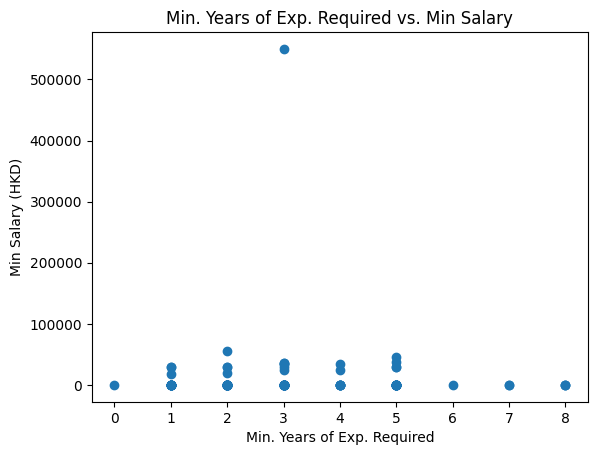

In [37]:
plt.scatter(x=df["Min. Years of Exp. Required"], y=df["Min_Salary"])
plt.title("Min. Years of Exp. Required vs. Min Salary")
plt.xlabel("Min. Years of Exp. Required")
plt.ylabel("Min Salary (HKD)")
plt.show()

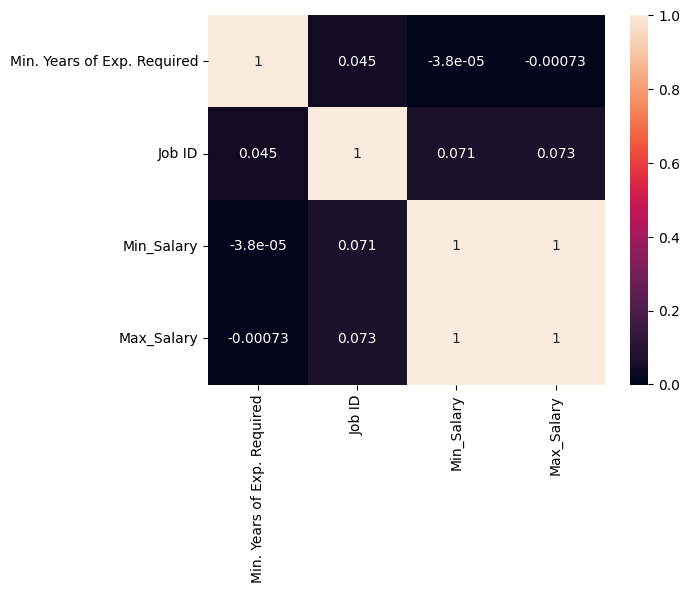

In [38]:
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True)
plt.show()


In [39]:
df_numerized = copy.deepcopy(df)

for col in df_numerized.columns:
    if(df_numerized[col].dtype == "object"):
        df_numerized[col] = df_numerized[col].astype("category")
        df_numerized[col] = df_numerized[col].cat.codes

df_numerized.head()

,Title,Company,Min. Years of Exp. Required,Fresh Grad/Less Exp.,Location,Classification,Salary,Posted Date,Job ID,URL,Exaction Location,District,Area,Min_Salary,Max_Salary
0,77,50,5,0,1,5,-1,19,77344899,144,1,3,2,0,0
1,50,61,1,-1,26,5,-1,13,76987834,22,-1,10,0,0,0
2,25,65,<NA>,-1,22,5,4,18,77341887,142,17,11,2,25000,34000
3,79,39,2,-1,19,5,-1,16,77338381,137,14,6,1,0,0
4,15,53,3,0,25,5,-1,19,77345435,145,19,0,0,0,0


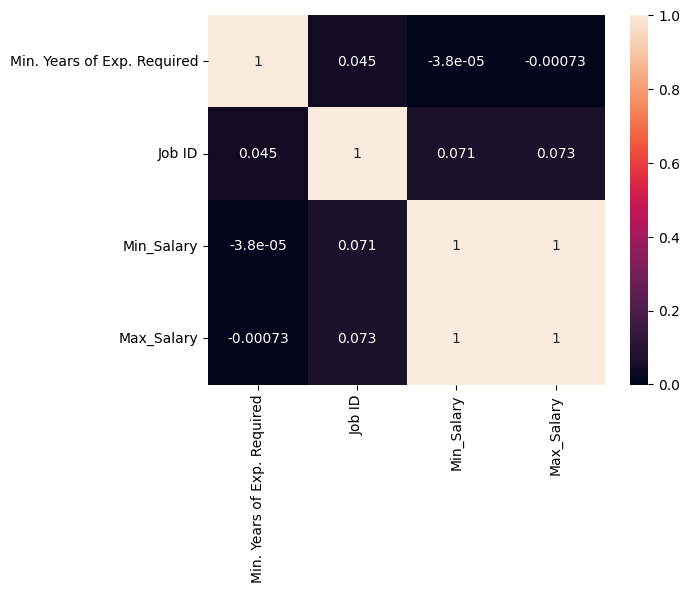

In [40]:
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True)
plt.show()


In [41]:
df.to_csv("./ba-analysis.csv", index=False)
print("\n\nsaved")



saved
